# Calculating Cooling/Heating Degree Days using daily projections from Cal-Adapt API

This notebook walks you through how we calculate Cooling and Heating Degree days for a county.

### Step 1. Select location
The daily maximum and minimum temperature datasets we will use in this exercise are raster datasets with a grid cell size of 1/16º (approximately 6 km). You can download data for an individual grid cell that corresponds to your area of interest or download data aggregated by a county boundary, watershed, etc. For a list of boundary layers supported by Cal-Adapt please see the API documentation. For this exercise we will use a county boundary from the County Boundaries data available through the Cal-Adapt API.

### Step 2. Download data
 - Download [observed daily maximum & minimum temperatures](http://cal-adapt.org/data/livneh/) for an area or grid cell.
 - Download [projected daily maximum & minimum temperatures](http://cal-adapt.org/data/loca/) for the location. We will use the 4 priority models and RCP 8.5 scenario (HadGEM2-ES, CNRM-CM5, CanESM2, MIROC5 models have been selected by [California’s Climate Action Team Research Working Group](http://climatechange.ca.gov/climate_action_team/research.html) as [priority models for research](http://docketpublic.energy.ca.gov/PublicDocuments/16-IEPR-04/TN215798_20170207T111409_Projected_Climate_Scenarios_Selected_to_Represent_a_Range_of_Po.pdf) contributing to California’s Fourth Climate Change Assessment).
 
### Step 3. Calculate Degree Days
 
 
You can modify this approach for your needs.

In [1]:
# A 'magic' command to display plots inline
%matplotlib inline

# Import all python modules. You need to run this cell for the other cells to work.
import requests 
import numpy as np
import pandas as pd
from datetime import datetime
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

# Cal-Adapt API
api = 'http://api.cal-adapt.org/api'
headers = {'ContentType': 'json'}

----
## Step 1. Select location
----

The `g` (geometry parameter) is used to download data for a point, line or polygon. Geometry can be written in various formats including WKT, GeoJSON, KML. The examples below use WKT (Well Known Text) format.

#### To get data for a grid cell ...

In [2]:
point = 'POINT(-121.4687 38.5938)'
data_download_params = {'g': point}

#### To get data for a user defined polygon ...

The `stat` parameter is used to spatially aggregate grid cell values. Accepted values are `mean`, `max`, `min`, `count`, `median`, `std`, `var`. If you don't provide the `stat` parameter the API will return an array of grid cell values.

You can create a new polygon using this [online WKT editor](https://arthur-e.github.io/Wicket/sandbox-gmaps3.html) or any GIS software.

In [3]:
polygon = 'POLYGON ((-123.35449 39.09596, -122.27783 39.09596, -122.27783 39.97712, -123.35449 39.97712, -123.35449 39.09596))' 
data_download_params = {'g': polygon, 'stat': 'mean'}

#### To get data for a polygon using one of the boundary layers in Cal-Adapt API

Instead of passing raw geometry like we did earlier using the `g` parameter, you can use another parameter called `ref`. This is a reference to the polygon feature on the API. Since we already have details for this feature, as long as you know it's id you don't need to pass in any geometry. This saves our server some time.

In [5]:
def get_polygon(intersecting_point, boundary):
    # Request url
    url = api + '/' + boundary + '/'
    # Request params
    params = {'intersects': intersecting_point, 'srs': 4326, 'simplify': .0001, 'precision': 4}
    # Make API request
    response = requests.get(url, params=params, headers=headers)
    if response.ok:
        data = response.json()
        feature = data['features'][0]
        if (feature):
            return feature
        else:
            return None

In [6]:
# Your point of interest
point = 'POINT(-121.4687 38.5938)'

# Name of boundary layer in API (Counties)
resource = 'counties'

# Polygon feature from resource that intersects your point
county = get_polygon(point, resource)

ref = '/api/%s/%s/' % (resource, county['id'])
data_download_params = {'ref': ref, 'stat': 'mean'}
data_download_params

{'ref': '/api/counties/34/', 'stat': 'mean'}

----
## Step 2. Download data
----

**Note: Requests might time out if the polygon is too large. If you need to process data for several boundaries we recommend downloading the daily rasters and processing the data locally.** 

Daily data is stored as a multiband raster, e.g. observed daily timeseries (1950 -2013) has 23376 bands with each band corresponding to one day, starting from 1950-01-01. Units for the observed data are degrees Celsius and projected data are in Kelvin.

The code in the next cell contains a bunch of functions to:
    - fetch daily data given a slug and query parameters
    - convert units to degrees F
    - return a new Pandas dataframe with the daily data

In [37]:
def celsius_to_F(val):
    return val * 9/5 + 32

def kelvin_to_F(val):
    return  (val - 273.15) * 9/5 + 32

def process_daily_data(item, params):
    # Create slug
    slug = '_'.join(item)
    
    # Make request
    url = api + '/series/' + slug + '/rasters/'
    response = requests.get(url, params=params)
    
    # Get data
    if response.ok:
        print('Processing:', slug)
        json = response.json()
        data = json['results'][0]

        # Multiband raster data is returned by the API as a 3D array having a shape like (233376, 1, 1)
        # Flatten the 3D array into a 1D array
        values_arr = np.array(data['image'])
        values_arr = values_arr.flatten()

        # Get total number of values -> number of days
        length = len(values_arr)

        # Get start date of timeseries
        start_date = datetime.strptime(data['event'], '%Y-%m-%d')

        # Create new pandas dataframe and map each value in list to a date index
        df = pd.DataFrame(
            values_arr,
            index=pd.date_range(start_date, freq='1D', periods=length),
            columns=['value'],
        )

        # Convert units to Fahrenheit
        units = data['units']
        if units == 'C':
            df.value = df.value.apply(lambda x: celsius_to_F(x))
        elif units == 'K':
            df.value = df.value.apply(lambda x: kelvin_to_F(x))
        else:
            pass
            
        # Add slug as a column
        df['climvar'] = item[0] 
        df['model'] = item[2]
        if (len(item) > 3):
            df['scenario'] = item[3]
        else: 
            df['scenario'] = 'historical'
    else:
        print('Failed to download:', slug)
            
    # Combine all the dataframes into one and return
    return df

### Get observed historical data

### Download projected daily tasmax & tasmin for a model

The projected daily timeseries are form 2006 - 2099/2100 and units are in degrees Kelvin. You can easily modify the code to add/subtract models, scenarios, climate variables

In [38]:
def get_observed():
    # Create an empty list to hold dataframes
    df_list = []

    # Make a combined list of GCMs, scenarios, climate variables for looping
    climvar = ['tasmax', 'tasmin']
    period = ['day']
    zipped = itertools.product(climvar, period, ['livneh'])

    # Loop through zipped
    for item in zipped:
        df = process_daily_data(item, data_download_params)
        df_list.append(df)
            
    # Combine all the dataframes into one and return
    return pd.concat(df_list)

In [39]:
observedDF = get_observed()
observedDF

Processing: tasmax_day_livneh
Processing: tasmin_day_livneh


,value,climvar,model,scenario
1950-01-01,47.537341,tasmax,livneh,historical
1950-01-02,43.417568,tasmax,livneh,historical
1950-01-03,46.940557,tasmax,livneh,historical
1950-01-04,43.705381,tasmax,livneh,historical
1950-01-05,45.215155,tasmax,livneh,historical
1950-01-06,48.405793,tasmax,livneh,historical
1950-01-07,50.585093,tasmax,livneh,historical
1950-01-08,50.540371,tasmax,livneh,historical
1950-01-09,50.566721,tasmax,livneh,historical
1950-01-10,49.278330,tasmax,livneh,historical


In [29]:
def get_model(name):
    # Create an empty list to hold dataframes
    df_list = []

    # Make a combined list of GCMs, scenarios, climate variables for looping
    climvar = ['tasmax', 'tasmin']
    period = ['day']
    scenarios = ['rcp45', 'historical']
    zipped = itertools.product(climvar, period, [name], scenarios)

    # Loop through zipped
    for item in zipped:
        df = process_daily_data(item, data_download_params)
        df_list.append(df)
            
    # Combine all the dataframes into one and return
    return pd.concat(df_list)

In [30]:
projectedDF = get_model('HadGEM2-ES')
projectedDF

Processing: tasmax_day_HadGEM2-ES_rcp45
Processing: tasmax_day_HadGEM2-ES_historical
Processing: tasmin_day_HadGEM2-ES_rcp45
Processing: tasmin_day_HadGEM2-ES_historical


,value,climvar,model,scenario
2006-01-01,48.389025,tasmax,HadGEM2-ES,rcp45
2006-01-02,43.415938,tasmax,HadGEM2-ES,rcp45
2006-01-03,37.246958,tasmax,HadGEM2-ES,rcp45
2006-01-04,42.387708,tasmax,HadGEM2-ES,rcp45
2006-01-05,45.945194,tasmax,HadGEM2-ES,rcp45
2006-01-06,44.388570,tasmax,HadGEM2-ES,rcp45
2006-01-07,48.789552,tasmax,HadGEM2-ES,rcp45
2006-01-08,46.718450,tasmax,HadGEM2-ES,rcp45
2006-01-09,53.679605,tasmax,HadGEM2-ES,rcp45
2006-01-10,54.822800,tasmax,HadGEM2-ES,rcp45


----
## Step 2. Calculate Extreme Heat threshold
----

For the Cal-Adapt Extreme Heat Tool, default Extreme Heat Threshold is the 98th percentile of historical maximum temperatures between April 1 and October 31 based on observed daily temperature data from 1961–1990. If you want to use a different cutoff temperature you can skip this step.

In [26]:
# Filter data by baseline time period
baselineDF = observedDF.loc['1961-01-01':'1990-12-31']

# Filter data by warm months
baselineDF = baselineDF[(baselineDF.index.month >= 4) & (baselineDF.index.month <= 10)]

print(baselineDF.head())
print()
print(baselineDF.tail())

                value               slug
1961-04-01  76.532000  tasmax_day_livneh
1961-04-02  82.345999  tasmax_day_livneh
1961-04-03  85.316002  tasmax_day_livneh
1961-04-04  81.410001  tasmax_day_livneh
1961-04-05  79.951999  tasmax_day_livneh

                value               slug
1990-10-27  83.768000  tasmax_day_livneh
1990-10-28  81.230001  tasmax_day_livneh
1990-10-29  75.398001  tasmax_day_livneh
1990-10-30  72.644000  tasmax_day_livneh
1990-10-31  71.042001  tasmax_day_livneh


In [27]:
threshold = baselineDF['value'].quantile(0.98, interpolation='linear')
print('Extreme Heat Threshold value for', location, 'is', round(threshold, 1), 'degrees Fahrenheit')

Extreme Heat Threshold value for Census Tract ID 6067006900 is 103.9 degrees Fahrenheit


----

## Step 3. Calculate number of extreme heat days
----

### 3a.  Find days above threshold from observed data

In [30]:
# Filter days > threshold
observed_heat_days = pd.DataFrame(observedDF[observedDF.value > threshold])
observed_heat_days['series'] = 'livneh'
observed_heat_days.index.name = 'date'
observed_heat_days = observed_heat_days.drop(['slug'], axis=1)

print(observed_heat_days.head())
print()
print(observed_heat_days.tail())

                 value  series
date                          
1950-06-29  106.088000  livneh
1950-06-30  108.338000  livneh
1950-07-01  109.417997  livneh
1950-07-02  108.212000  livneh
1950-08-17  104.108002  livneh

                 value  series
date                          
2013-06-29  106.772002  livneh
2013-06-30  105.529997  livneh
2013-07-01  105.044003  livneh
2013-07-03  104.558002  livneh
2013-07-04  108.086001  livneh


### 3b. Find days above threshold from projected data

In [31]:
# Filter days > threshold
projected_heat_days = pd.DataFrame(projectedDF[projectedDF.value > threshold])
projected_heat_days['series'] = projected_heat_days['slug'].str.split('_', expand=True)[2]
projected_heat_days.index.name = 'date'
projected_heat_days = projected_heat_days.drop(['slug'], axis=1)

print(projected_heat_days.head())
print()
print(projected_heat_days.tail())

                 value   series
date                           
2006-05-29  105.571913  CanESM2
2006-05-30  105.439308  CanESM2
2006-06-25  107.808729  CanESM2
2006-06-26  105.881453  CanESM2
2006-06-27  104.827534  CanESM2

                 value  series
date                          
2003-08-03  107.251173  MIROC5
2003-08-04  106.393031  MIROC5
2003-08-05  104.088484  MIROC5
2005-07-27  104.651094  MIROC5
2005-07-29  104.149952  MIROC5


----
## Step 4.  Report projected Extreme heat days
----

### 4a. Number of extreme heat days by year from observed data, averaged over 1961-1990

In [33]:
# Filter dates by baseline time period
baseline_heat_days = observed_heat_days.loc['1961-01-01':'1990-12-31']
# Group by year and calculate mean
count = baseline_heat_days.value.resample('1AS').count().mean()
print('Historically (1961-1990)', location, 'County had an average of', int(count), 'days with daily highs above', round(threshold, 1), 'degrees F')

Historically (1961-1990) Census Tract ID 6067006900 County had an average of 4 days with daily highs above 103.9 degrees F


### 4b. Number of extreme heat days by year from HadGEM2-ES RCP 4.5, averaged over 2070-2099

In [38]:
# Filter dates by end of century time period
century_end_heat_days = projected_heat_days.loc['2070-01-01':'2099-12-31']

In [39]:
heat_days = century_end_heat_days.loc[century_end_heat_days['series'] == 'HadGEM2-ES']
count = heat_days.value.resample('1AS').count().mean()
print('If current emission trends peak around 2040 and then decline (RCP 4.5)', location, 'will have an average of', int(count), 'days with daily highs above', round(threshold, 1), 'degrees F by end of century (2070-2099) under simulated warmer/drier conditions (HadGEM2-ES)')

If current emission trends peak around 2040 and then decline (RCP 4.5) Census Tract ID 6067006900 will have an average of 28 days with daily highs above 103.9 degrees F by end of century (2070-2099) under simulated warmer/drier conditions (HadGEM2-ES)


### 4c. Plot Number of Extreme Heat Days by Year

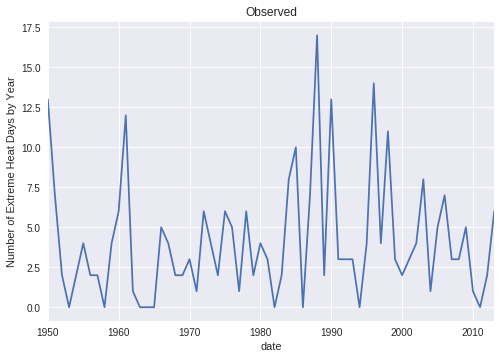

In [40]:
observed_count_by_year = observed_heat_days.value.resample('1AS').count()

# Plot
observed_count_by_year.plot()
plt.title("Observed")
plt.ylabel("Number of Extreme Heat Days by Year")

In [41]:
projected_count_by_year = projected_heat_days.groupby(['series']).value.resample('1AS').count().unstack('series')
projected_count_by_year

series,CNRM-CM5,CanESM2,HadGEM2-ES,MIROC5
date,,,,
1950-01-01,2.0,2.0,2.0,3.0
1951-01-01,4.0,6.0,5.0,11.0
1952-01-01,2.0,3.0,2.0,3.0
1953-01-01,5.0,3.0,10.0,3.0
1954-01-01,4.0,4.0,2.0,14.0
1955-01-01,4.0,7.0,1.0,6.0
1956-01-01,11.0,1.0,12.0,2.0
1957-01-01,1.0,1.0,12.0,7.0
1958-01-01,0.0,6.0,4.0,4.0


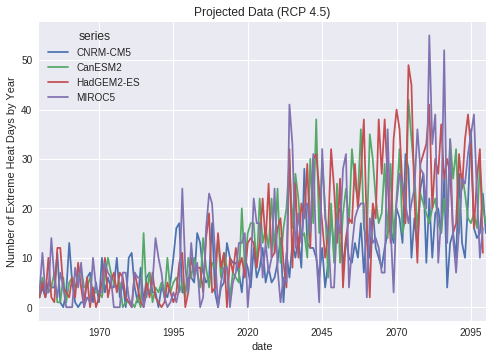

In [42]:
# Plot
projected_count_by_year.plot()
plt.title("Projected Data (RCP 4.5)")
plt.ylabel("Number of Extreme Heat Days by Year")
